In [2]:
#############################################################################
#                              Introduction                                 #
#############################################################################
# First of all thanks to jeff heaton                                        #                              
# the creator of this data set for uploading this.                          #
#                                                                           #
# So Iris is probably one of the first data sets a ML                       #
# students learns to work with. (in csv format, not images!!)               #
#                                                                           #
# The objective for this notebook is the various approaches we can          #
# classify the Iris Flower  (3 Aprroaches)                                  #
#############################################################################

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install tensorflow


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
###############################################################
# Approach one training our own CNN                           #
###############################################################


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
import pathlib

## Defining batch specfications
batch_size = 10
img_height = 224
img_width = 224

data_dir = pathlib.Path('images')


## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset= "training",
  seed=42,
  image_size= (img_height, img_width),
  batch_size=batch_size

)

## loading testing data
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset= "validation",
  seed=42,
  image_size= (img_height, img_width),
  batch_size=batch_size

)

class_names = training_ds.class_names


## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

## lets define our CNN
## This is my usual Network structure
## works fine in most casses

MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## lets train our CNN
retVal = MyCnn.fit(training_ds,validation_data= validation_ds,epochs = 5)


Found 421 files belonging to 3 classes.
Using 337 files for training.
Found 421 files belonging to 3 classes.
Using 84 files for validation.
Epoch 1/5
 5/34 [===>..........................] - ETA: 58s - loss: 7.7426 - accuracy: 0.3800 

1/1 [==============================] - 1s 980ms/step


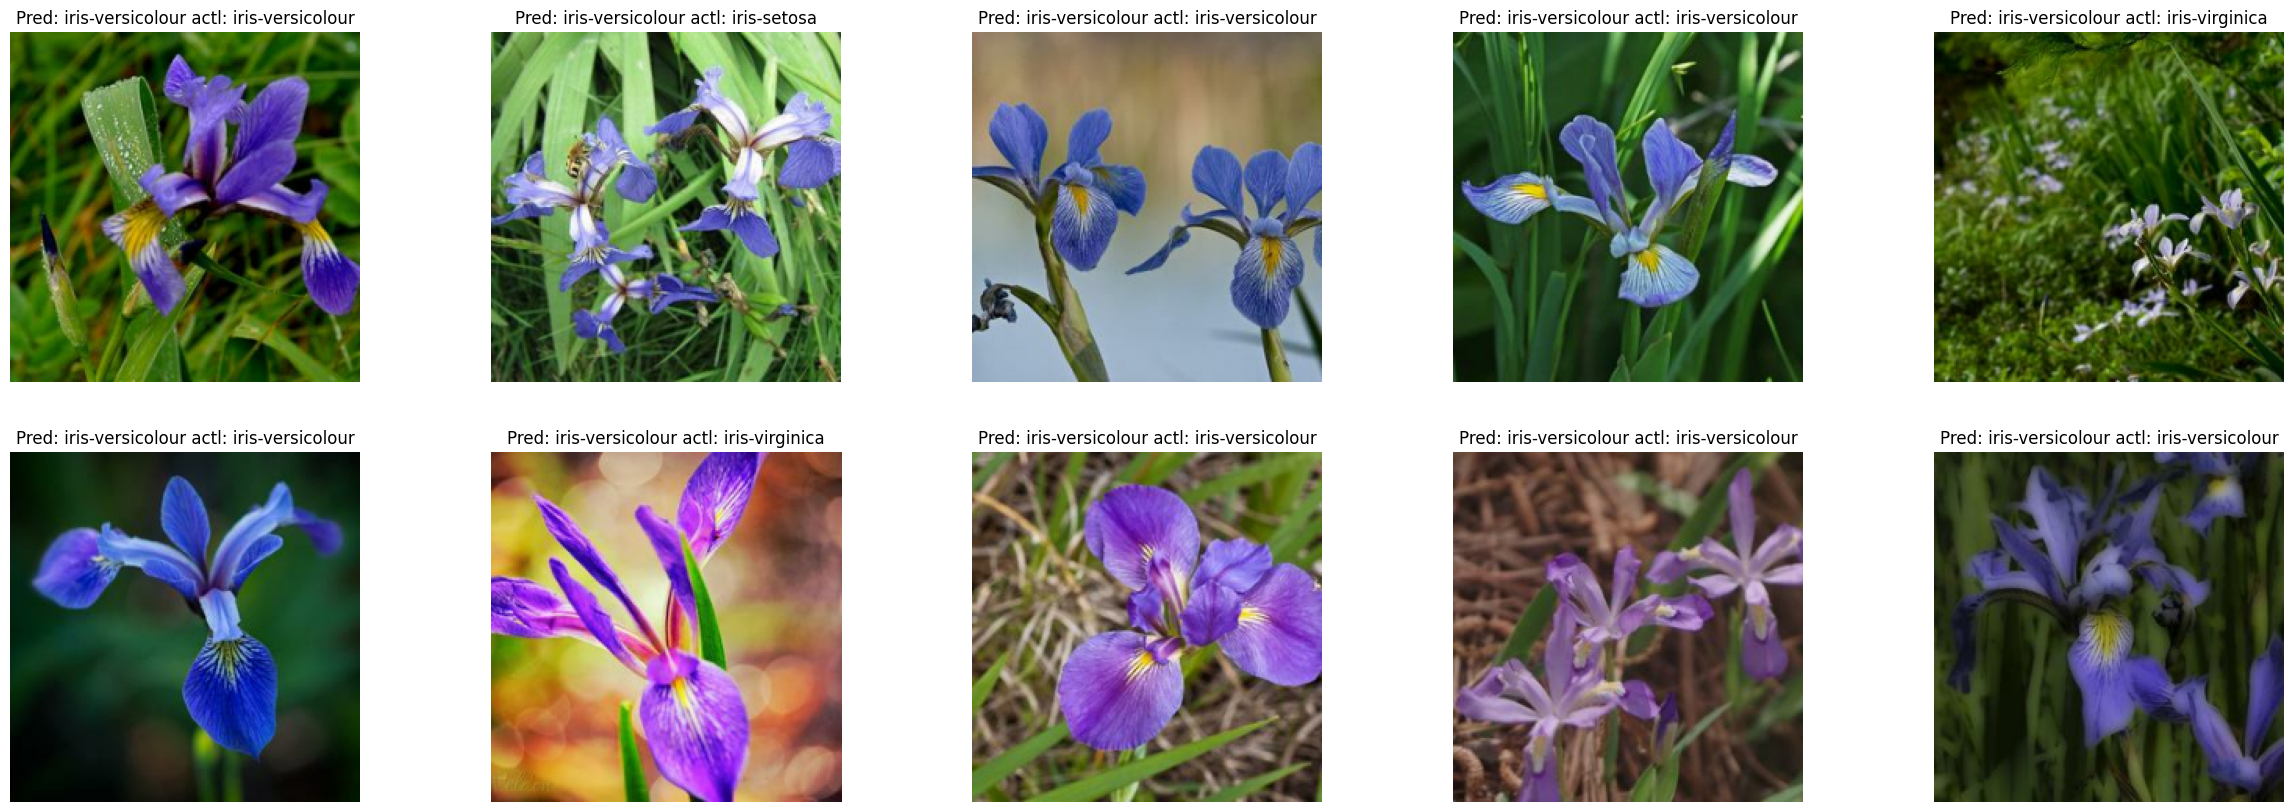

In [3]:
###############################################################
#                    Comments                                 #
###############################################################
# one observation to state here training this model for more  #
# than 5 epochs leads to overfitting, wherein training acc    #
# goes up but validation accuracy goes down                   #
#                                                             #
# using dropout will work but not putting that here           #
# lets visualize our models specs                             #
###############################################################


## plotting results
plt.figure(figsize=(30, 10))
for images, labels in validation_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl: '+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

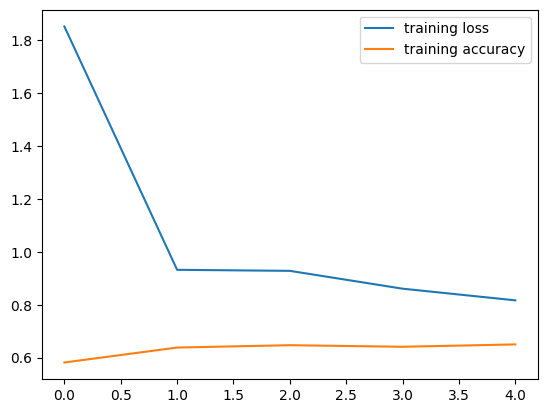

In [4]:
## training loss
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

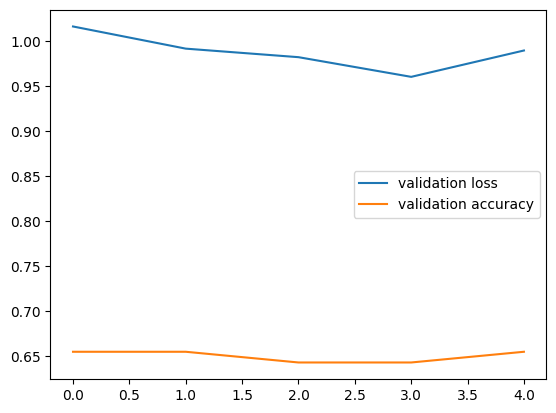

In [5]:
## validation loss and accuracy 
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

############################################
# so this seems we obtained validaton acc  #
# of around 65 % lets try to do better     #
############################################

In [6]:
#############################################################################
# Approach 2: Transfer learning using InceptionResnetV2                     #
#############################################################################

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model

pretrained = InceptionResNetV2(include_top=True,weights='imagenet')
x=pretrained.layers[-2].output
predLayer = Dense(len(class_names),activation='softmax')(x)
MyCnn = Model(inputs=pretrained.input,outputs=predLayer)

## freezing initial layers
for layer in MyCnn.layers[:-40] :
    layer.trainable = False
    

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##learning rate rescheduling
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * 0.3
    
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
## lets train our model
retVal = MyCnn.fit(training_ds, validation_data=validation_ds, callbacks=[callback], epochs= 5)

225209952/225209952 [==============================] - 50s 0us/step
Epoch 1/5


ValueError: in user code:

    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\abelb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


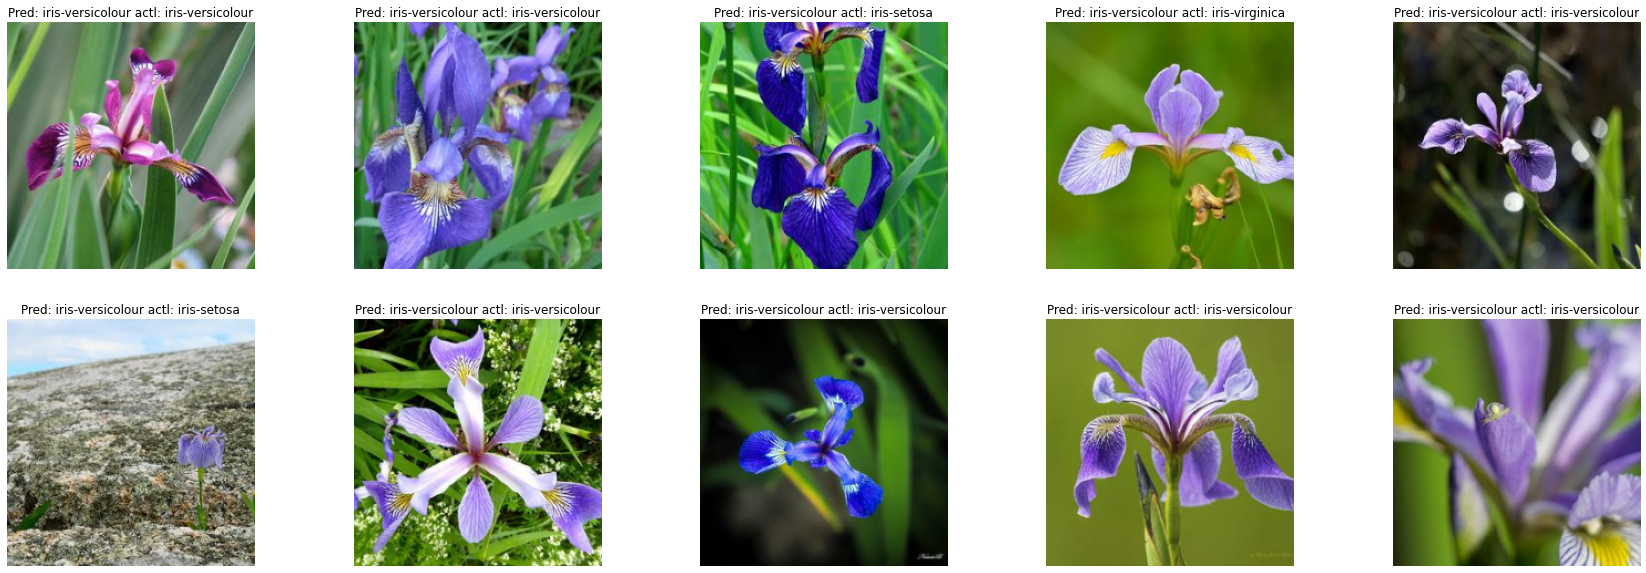

In [ ]:
#############################################################
#  again 65% !!! lets visualize                             #
#############################################################

## plotting results
plt.figure(figsize=(30, 10))
for images, labels in validation_ds.take(3):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl: '+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

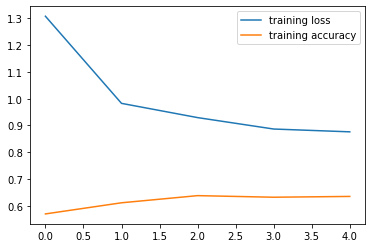

In [ ]:
## training loss
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

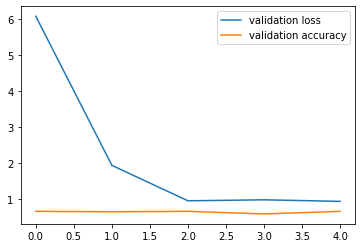

In [ ]:
## validation loss and accuracy 
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

In [9]:
%pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: C:\Users\abelb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
##################################################################
#  Approach 3 : using a pretrained CNN and Kmeans clustering     #
##################################################################

## A data structure  for holding flattenimages 
## alongside image name
DataFrame = {
    'photo_name' : [],
    'flattenPhoto' : [],
    'class' : []
    }

#Loading model
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet101(
    include_top = False, weights='imagenet', pooling='avg',))

# freezing weights for 1st layer
MyModel.layers[0].trainable = False

##############################################################################################
#                                  What we Are doing here ??                                 #
##############################################################################################
# We are using a pretrained model as a feature extractor (here) resnet50                     #
# using these extracted features we will be using kmeans/ agglo clustering to cluster similar#
# images together                                                                            #
##############################################################################################

import cv2
### Now defining dataloading Function
def LoadDataAndDoEssentials(path, h, w):
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    ## Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = MyModel.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    DataFrame['flattenPhoto'].append(extractedFeatures.flatten())
    
## iterrator function
def ReadAndStoreMyImages(path, cls):
    list_ = os.listdir(path)

    for mem in list_:
        DataFrame['photo_name'].append(mem)
        DataFrame['class'].append(cls)
        imagePath = path + '/' + mem
        LoadDataAndDoEssentials(imagePath, 224, 224)

## loading data into our ds
path1 = '/kaggle/input/iris-computer-vision/iris-setosa'
path2 = '/kaggle/input/iris-computer-vision/iris-versicolour'
path3 = '/kaggle/input/iris-computer-vision/iris-virginica'


ReadAndStoreMyImages(path1, 'setosa')
ReadAndStoreMyImages(path2, 'versicolour')
ReadAndStoreMyImages(path3, 'virginica')


ModuleNotFoundError: No module named 'cv2'

In [ ]:
######################################################
#        lets now do clustering                      #
######################################################

Training_Feature_vector = np.array(DataFrame['flattenPhoto'], dtype = 'float64')
from sklearn.cluster import AgglomerativeClustering
kmeans = AgglomerativeClustering(n_clusters = 3)
kmeans.fit(Training_Feature_vector)



AgglomerativeClustering(n_clusters=3)

In [ ]:
kmeans.labels_

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1,
       0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0,
       1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1,

In [ ]:
## lets draw some conclusions form the above
def drawConclusions():
    zeroCount = 0 
    oneCount = 0
    twoCount = 0

    for mem in kmeans.labels_ :
        if mem == 0:
            zeroCount += 1
        elif mem == 1:
            oneCount += 1
        elif mem == 2:
            twoCount += 1
            
    per0 = zeroCount / len(kmeans.labels_)
    per1 = oneCount / len(kmeans.labels_)
    per2 = twoCount / len(kmeans.labels_)
    
    print ('No. of samples classified in category zero: ' + str(zeroCount) + ' and their % is : ' + str(per0))
    print ('No. of samples classified in category one: ' + str(oneCount) + ' and their % is : ' + str(per1))
    print ('No. of samples classified in category two: ' + str(twoCount) + ' and their % is : ' + str(per2))
    
drawConclusions()

No. of samples classified in category zero: 269 and their % is : 0.6389548693586699
No. of samples classified in category one: 92 and their % is : 0.21852731591448932
No. of samples classified in category two: 60 and their % is : 0.14251781472684086


In [ ]:
## In the given dataset :
## num setosa Images = 67
## num versicolor Images = 269
## num virginica Images = 85

## Hence Total images = 421
## % setosa =  67/ 421  * 100 ~ 16 %
## % vericolor = 269/421 * 100 ~  64 % 
## % virginica = 85/421 * 100 ~ 20 % 

### Which I guess is quite good hence assign setosa cluster two
## vericolour to cluster cluster zero
## virginica to cluster one 

predictions = kmeans.labels_
classPred = []
for mem in predictions:
    if mem == 0:
        classPred.append('versicolour')
    elif mem == 1:
        classPred.append('virginica')
    elif mem == 2:
        classPred.append('setosa')


In [ ]:
## let calculate accuracy
acc = 0
for trueLabel, predictedLabel in zip(DataFrame['class'], classPred):
    if trueLabel == predictedLabel:
        acc += 1

print ('Accuracy for third approach is {}'.format(acc/421))

Accuracy for third approach is 0.4584323040380047


In [ ]:
#########################################################
#                    Conclusion                         #
#########################################################
# with both CNN (our model and that used for transfer   #
# learning ) we acheived an acc. of 65.48 %             #
#                                                       #
# with our 3rd approach acc. drops to only 45%          #
#########################################################

##########################################################
# Your Comments are welcome, if you know a way to better #
# up the classification scores do let me know            #
# Thanks                                                 #
##########################################################